# Perspective-Equivariant Imaging: an Unsupervised Framework for Multispectral Pansharpening

[![arXiv](https://img.shields.io/badge/arXiv-<INDEX>-<COLOR>.svg)](https://arxiv.org/abs/<INDEX>)
[![GitHub](https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/Andrewwango/perspective-equivariant-imaging)
[Webpage](https://andrewwango.github.io/perspective-equivariant-imaging) | [Notebook](demo.ipynb)

**Authors**: Andrew Wang, Mike Davies, School of Engineering, University of Edinburgh

**Abstract**: Ill-posed image reconstruction problems appear in many scenarios such as remote sensing, where obtaining high quality images is crucial for environmental monitoring, disaster management and urban planning. Deep learning has seen great success in overcoming the limitations of traditional methods. However, these inverse problems rarely come with ground truth data, highlighting the importance of unsupervised learning from partial and noisy measurements alone. We propose _perspective-equivariant imaging_ (EI), a framework that leverages perspective variability in optical camera-based imaging systems, such as satellites or handheld cameras, to recover information lost in ill-posed optical camera imaging problems. This extends previous EI work to include a much richer non-linear class of group transforms and is shown to be an excellent prior for satellite and urban image data, where perspective-EI achieves state-of-the-art results in multispectral pansharpening, outperforming other unsupervised methods in the literature.

**Citation**
```
@article{wang2024perspective,
  title={Perspective-Equivariant Imaging: an Unsupervised Framework for Multispectral Pansharpening},
  author={Wang, Andrew and Davies, Mike},
  year={2024},
  url={https://arxiv.org/abs/<INDEX>}
}
```

## 1. Results

![](img/eval_spacenet_pansharpen_noiseless.png)

In [1]:
#| echo: false
import warnings
warnings.filterwarnings('ignore')

In [2]:
#| output: false
import deepinv as dinv
from perspective_ei import *
device = get_device()

Selected GPU 0 with 11016 MB free memory 


## 2. Background
### 2.1 Multispectral pansharpening

The pansharpening inverse problem seeks to recover high-resolution multispectral (HRMS) images $x$ from low-resolution multispectral (LRMS) $\mathbf{y}_\text{MS}$ and high-resolution panchromatic (single-band) $\mathbf{y}_\text{pan}$ images. The forward operator is:

$$\left\{\mathbf{y}_\text{MS},\mathbf{y}_\text{PAN}\right\}\sim\mathcal{P}\left(\mathbf{A}_\text{PS}\mathbf{x}\right)=\left\{\mathcal{P}\left(\mathbf{A}_\text{SR}\mathbf{x}\right),\mathcal{P}\left(\mathbf{R}_\text{PAN}\mathbf{x}\right)\right\}$$

where $\mathbf{R}_\text{PAN}$ is the pan channel's SRF, $\mathbf{A}_\text{SR}\mathbf{x}=(\mathbf{k} * \mathbf{x}) \downarrow_j$ is the $j\times j$-factor downsampling operator with anti-aliasing kernel $\mathbf{k}$, and $\mathcal{P}$ is the Poisson noise operator. We simulate a tiny dataset of WorldView-2 tiles taken from [SpaceNet-4](https://spacenet.ai/off-nadir-building-detection/) (see [vis](data/spacenet/vis/)):

In [3]:
dataset_name = "spacenet"
noise_gain = 0.
img_shape = (4, 1024, 1024)
ratio = 4

In [4]:
physics = Pansharpen(img_shape, factor=ratio, device=device)

if noise_gain > 0.0:
    physics.noise_model = dinv.physics.PoissonNoise(gain=noise_gain, clip_positive=True) 

In [5]:
#| output: false
train_dataloader, test_dataloader = make_dataloaders(dataset_name, physics, device=device)

Computing train measurement vectors from base dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.72s/it]


Computing test measurement vectors from base dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.48s/it]

Dataset has been saved in data/spacenet


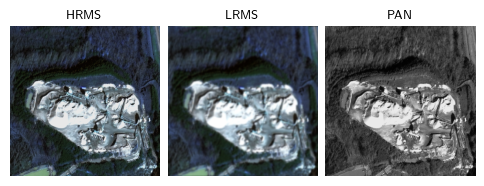

In [8]:
x, y = next(iter(test_dataloader))
x, y = x.to(device), y.to(device)
plot_multispectral(x, y)

### 2.2 Projective transformations

Camera-based imaging systems move and rotate freely in the world. In satellite imaging, scenes are generally imaged off-nadir, i.e. the focal line does not pass through the Earth point located vertically below, resulting in a perspective distortion. 

Our proposed perspective-EI uses the natural belief that unknown image sets are invariant to changes in perspective to solve these inverse problems without ground truth (GT), by considering the group of non-linear projective transformations $\mathbf{T}_g$. Note that we **do not have** access to the GT images $x$, we just show these for demonstration:

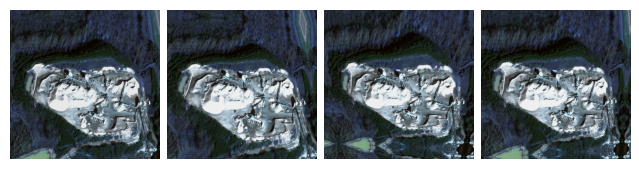

In [9]:
transform = Homography(
    n_trans = 1, 
    theta_max = 5, #degrees 
    theta_z_max = 0, 
    shift_max = 0, 
    skew_max = 0,
    zoom_factor_min = 1,
    x_stretch_factor_min = 1, 
    y_stretch_factor_min = 1, 
    device=device
    )

plot_multispectral([x, transform(x), transform(x), transform(x)])

### 2.3 Perspective-equivariant imaging

The EI framework learns to invert from measurements $y$ alone:

<img src="img/diag_EI.jpg" width="50%"/>

Our proposed loss function adds perspective-EI onto a spectral and structural measurement consistency (MC) loss:

$$\mathcal{L}_\text{unsup}(\theta;\mathbf{y},g)=\lVert\mathbf{A}f_\theta(\mathbf{y})-\mathbf{y}_\text{MS}\rVert_2^2+\lVert \mathbf{R}_\text{pan}f_\theta(\mathbf{y})-\mathbf{y}_\text{pan}\rVert_\text{TV}+\mathcal{L}_\text{EI}(\theta;\mathbf{y},g)$$

In the noisy scenario, both the spectral and structural MC losses are replaced by SURE losses. We assume a flat $\mathbf{R}_\text{pan}$ that simply averages the channels.

In [10]:
if noise_gain > 0:
    loss_spectral   = SurePoissonSpectralLoss(gain=noise_gain, tau=1e-2) #tau from (Chen et al. 2022: Robust Equivariant Imaging, Appendix C.3)
    loss_structural = SurePoissonStructuralLoss(gain=noise_gain, tau=1e-2, srf_from="average")
else:
    loss_spectral   = dinv.loss.MCLoss(metric=LRMS_MSELoss(ratio))
    loss_structural = TVStructuralLoss(srf_from="average")

losses = [loss_spectral, loss_structural, dinv.loss.EILoss(transform, metric=HRMS_MSELoss(), weight=1.)]

## 3. Training

We train with the [PanNet](https://ieeexplore.ieee.org/document/8237455) neural network, but any NN model can be used since our method is independent of the choice of NN. We train our models using [deepinv](https://deepinv.github.io/) which is built on PyTorch.

In [11]:
model = PanNet(
    backbone_net=ResNet(hidden_channels=32, num_blocks=4), 
    hrms_shape=img_shape, 
    scale_factor=ratio,
    highpass_kernel_size=51,
    device=device,
).to(device)

In [18]:
optimizer, scheduler = make_optimizer_scheduler(model, lr_init=1e-3)

model = dinv.train(
    epochs=10,
    model=model,
    losses=losses,
    physics=physics,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    scheduler=scheduler,
    optimizer=optimizer,
    device=device,
    verbose=True,
    ckp_interval=99,
    img_interval=99,
    freq_plot=99,
)

The model has 77124 trainable parameters


Epoch 1: 100%|█| 10/10 [00:04<00:00,  2.46it/s, eval_psnr=20.3, loss_mc=0.0103, loss_TVStructural=0.000693, loss_ei=0.00
Epoch 2: 100%|█| 10/10 [00:03<00:00,  2.55it/s, eval_psnr=19.2, loss_mc=0.00687, loss_TVStructural=0.000447, loss_ei=0.0
Epoch 3: 100%|█| 10/10 [00:03<00:00,  2.51it/s, eval_psnr=19.5, loss_mc=0.00644, loss_TVStructural=0.000495, loss_ei=0.0
Epoch 4: 100%|█| 10/10 [00:03<00:00,  2.53it/s, eval_psnr=21.6, loss_mc=0.00677, loss_TVStructural=0.000509, loss_ei=0.0
Epoch 5: 100%|█| 10/10 [00:03<00:00,  2.53it/s, eval_psnr=21.5, loss_mc=0.00596, loss_TVStructural=0.00043, loss_ei=0.00
Epoch 6: 100%|█| 10/10 [00:03<00:00,  2.53it/s, eval_psnr=21.2, loss_mc=0.00577, loss_TVStructural=0.000453, loss_ei=0.0
Epoch 7: 100%|█| 10/10 [00:04<00:00,  2.48it/s, eval_psnr=22.4, loss_mc=0.00519, loss_TVStructural=0.000444, loss_ei=0.0
Epoch 8: 100%|█| 10/10 [00:04<00:00,  2.50it/s, eval_psnr=22.9, loss_mc=0.00497, loss_TVStructural=0.000475, loss_ei=0.0
Epoch 9: 100%|█| 10/10 [00:03<00

### 3.1 Evaluation metrics

We report QNR (no reference) ERGAS, and PSNR. See [Meng et al.](https://ieeexplore.ieee.org/document/9082183) benchmark for details.

In [20]:
model.eval()

x_hat = model(y.to(device), physics).detach()

qnr = QNR(physics, alpha=1., beta=1.5)(x_hat, y)
from torchmetrics.functional.image import error_relative_global_dimensionless_synthesis
ergas = error_relative_global_dimensionless_synthesis(x_hat, x, ratio=0.25).item()
psnr = dinv.utils.cal_psnr(x_hat, x)

print(f"QNR: {round(qnr, 3)}, PSNR: {round(psnr, 2)}, ERGAS: {round(ergas, 2)}")

QNR: 0.776, PSNR: 18.65, ERGAS: 8.34


## 4. Competitors

We compare our pansharpening loss with 4 unsupervised methods from the literature: the losses from [GDD](https://arxiv.org/abs/2007.11766), [SSQ](https://ieeexplore.ieee.org/document/9136909), [Z-PNN](https://ieeexplore.ieee.org/document/9745494) and [PanGan](https://www.sciencedirect.com/science/article/abs/pii/S1566253520302591).

To train with them, simply replace `losses` with one of the following:

In [ ]:
from perspective_ei.multispectral.competitors import *

GDD_losses = [
    dinv.loss.MCLoss(metric=LRMS_MSELoss(ratio)), 
    TVStructuralLoss(srf_from="average")
]

SSQ_losses = [
    SSQSpectralLoss(device=device), 
    SSQStructuralLoss(srf_from="average"), 
    QNRLoss()
]

ZPNN_losses = [
    dinv.loss.MCLoss(metric=LRMS_L1Loss(ratio)), 
    ZPNN_CorrelationLoss(device=device)
]

PanGan_losses = [
    dinv.loss.MCLoss(metric=LRMS_MSELoss(ratio)), 
    PanganStructuralLoss(srf_from="average", device=device),
    PanganAdvGenLoss(srf_from="average", device=device),
    PanganAdvDiscrimSpectralLoss(device=device),
    PanganAdvDiscrimStructuralLoss(srf_from="average", device=device)
] # see perspective_ei.multispectral.competitors.pangan for training details